# Quadruped INS



In [1]:
%matplotlib inline

In [2]:
import numpy as np # matrix manipulations
from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
# import pylab                                   # this allows you to control figure size 
# pylab.rcParams['figure.figsize'] = (10.0, 10.0) # this controls figure size in the notebook
from pygecko import IMU, Vector

In [3]:
from math import sin, cos, atan2, pi, sqrt, asin
from math import radians as deg2rad
from math import degrees as rad2deg

In [4]:
import pickle
data = pickle.load(open("accel-z-up.pickle","rb"))

# data is an array of IMU messages
data[0]

IMU(linear_accel=Vector(x=0.03294, y=-0.08881599999999999, z=1.011868), angular_vel=Vector(x=4.5, y=-9.200000000000001, z=-11.5), magnetic_field=Vector(x=-1.5078125, y=2.625, z=0.2265625), timestamp=1536007764.8121648)

In [5]:
from squaternion import Quaternion, euler2quat, quat2euler, quatNorm

In [6]:
#your python code here
def normalize(x, y, z):
    """Return a unit vector"""
    norm = sqrt(x * x + y * y + z * z)

    # already a unit vector
    if norm == 1.0:
        return (x, y, z)

    if norm > 0.0:
        inorm = 1/norm
        x *= inorm
        y *= inorm
        z *= inorm
    else:
        raise Exception('division by zero: {} {} {}'.format(x, y, z))
    return (x, y, z,)

def skew4(wx, wy, wz):  # titterton 11.35
    return np.array([
        (0, -wx, -wy, -wz),
        (wx, 0, wz, -wy),
        (wy, -wz, 0, wx),
        (wz, wy, -wx, 0)
    ])

def skew3(wx, wy, wz):
    return np.array([
        (0, -wz, wy),
        (wz, 0, -wx),
        (-wy, wx, 0)
    ])

In [7]:
def gps2ecef(lat, lon, H):
    # phi = lat
    # lambda = lon
    # H = height above mean sea-level (altitude)
    e = 1.0
    re = 6378137.0  # radius of Earth in meters
    
    # convert degrees to angles
    lat *= pi/180
    lon *= pi/180
    
    rm = re * (1.0 - e**2) / pow(1.0 - e**2 * sin(lat)**2, 3.0 / 2.0)
    rn = re / sqrt(1.0 - e**2 * sin(lat)**2)
    x = (rn + H) * cos(lat) * cos(lon)
    y = (rn + H) * cos(lat) * sin(lon)
    z = (rm + H) * sin(lat)
    return x, y, z

In [8]:
from pyrk import RK4

class Sim(object):
    def __init__(self, eom, a, g, tm):
        self.eom = eom
        
        # grab the inertial sensors
#         self.accels = [x.linear_accel for x in imu]
#         self.gyros = [x.angular_vel for x in imu]
#         self.mags = [x.magnetic_field for x in imu]
        self.accels = a
        self.gyros = g
        self.dts = tm
        
        # make a relative delta time from the first time step
#         dts = [x.timestamp for x in imu]
#         start = dts[0]
#         self.dts = [x - start for x in dts]
#         self.dts = np.arange(0, (len(a)-1)*0.1, 0.1)  # 10Hz
    
#         print(len(a))
#         print(len(g))
#         print(len(self.dts))
    
    def run_nav(self):
        """
        These are the navigation only equations, no EKF corrections
        """
        rk = RK4(self.eom)
        
        # initial states
        vel = (0,0,0)
        pos = (0,0,0)
        orient = (1,0,0,0)
        X = np.array(vel + pos + orient)
        
        save = []
        
        last = self.dts[0]-0.1
        for i, tm in enumerate(self.dts):
            u = self.accels[i] + self.gyros[i]
            X = rk.step(X,u,tm,tm-last)
            last = tm
            save.append(X)
            
        print(">> Simulation end: {:.2f} seconds".format(tm))
            
        return save, self.dts

In [9]:
accels = [(x.linear_accel.x,x.linear_accel.y,x.linear_accel.z,) for x in data]
gyros = [(
    x.angular_vel.x * pi / 180,
    x.angular_vel.y * pi / 180,
    x.angular_vel.z * pi / 180,) for x in data]
stamps = [x.timestamp - data[0].timestamp for x in data]

In [10]:
ax = np.mean([x[0] for x in accels])
ay = np.mean([x[1] for x in accels])
az = np.mean([x[2] for x in accels]) - 1.0
print('Accels mean: {:.4f} {:.4f} {:.4f}'.format(ax,ay,az))

gx = np.mean([x[0] for x in gyros])
gy = np.mean([x[1] for x in gyros])
gz = np.mean([x[2] for x in gyros])
print('Gyro mean: {:.4f} {:.4f} {:.4f}'.format(gx,gy,gz))

Accels mean: 0.0336 -0.0884 0.0135
Gyro mean: 0.0857 -0.1646 -0.2179


In [11]:
accels = [(
    x.linear_accel.x - ax,
    x.linear_accel.y - ay,
    x.linear_accel.z - az,) for x in data]
gyros = [(
    x.angular_vel.x*pi/180 - gx,
    x.angular_vel.y*pi/180 - gy,
    x.angular_vel.z*pi/180 - gz,) for x in data]

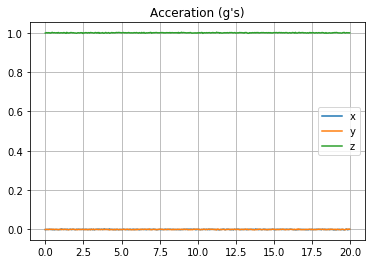

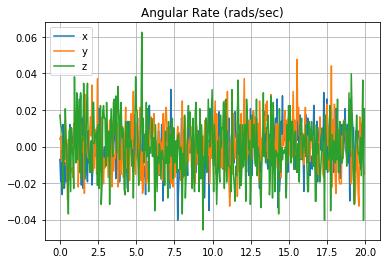

In [12]:
for s, title in zip([accels, gyros], ['Acceration (g\'s)', 'Angular Rate (rads/sec)']):
    plt.figure()
    plt.plot(stamps, [x[0] for x in s], label='x')
    plt.plot(stamps, [x[1] for x in s], label='y')
    plt.plot(stamps, [x[2] for x in s], label='z')
    plt.grid(True)
    plt.title(title)
    plt.legend()

In [13]:
# System equations of motion (eom)
# these follow the Titterton ECEF derivation
def eom(t, X, u):
    """
    State vector
    X = tuple[vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    These are sensor readings from IMU
    u = [fx fy fz wx wy wz]
    f - force (acceleration)
    w - angular velocity (from gyros)
    """
    # imu ---------------------
    f = 9.81*np.array(u[0:3]) 
    wx, wy, wz = u[3:]
    W = skew4(wx, wy, wz)
    
    # state -------------------
    v = np.array(X[0:3])
    p = np.array(X[3:6])
    q = np.array(X[6:])
    
    # nav const --------------
    wie = np.array([0, 0, 7.292115E-15])
    Ceb = np.eye(3) # ???
    g = np.array([0,0,-9.81])
    
    # update local gravity model
    gl = g - np.cross(wie, np.cross(wie, p))
    
    # velocity update
    vd = Ceb.dot(f)-2.0*np.cross(wie, np.cross(wie, v)) + gl
    
    # position update
    pd = v
    
    # orientation update
    qd = 0.5 * W.dot(q)

    # print('vd', vd)
    # print('pd', pd)
    # print('qd', qd)

    XX = np.hstack((vd, pd, qd))
    return XX

In [63]:
# filter doesn't seem to really help much
# fgyros = [(x,y,z,) for x,y,z in zip(fgx, fgy, fgz)]

s = Sim(eom, accels, gyros, stamps)
X, timestamps = s.run_nav()

>> Simulation end: 19.95 seconds


In [64]:
vel = [x[:3] for x in X]
pos = [x[3:6] for x in X]
orient = [x[6:] for x in X]

# print(len(stamps))
# print(len(pos))

400
400


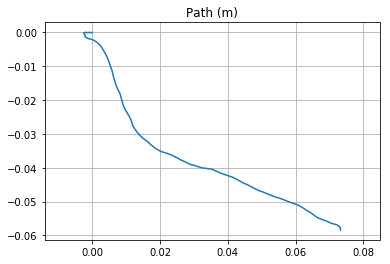

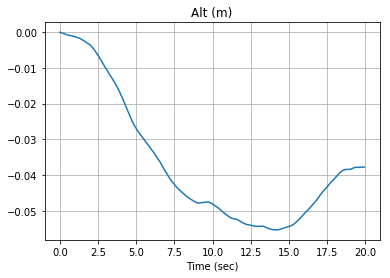

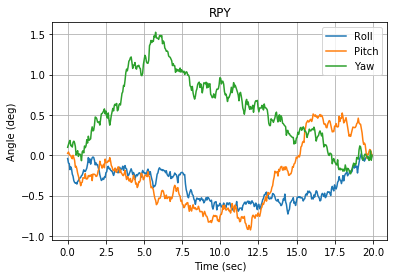

In [65]:
x = [x[0] for x in pos]
y = [x[1] for x in pos]
z = [x[2] for x in pos]

plt.figure()
plt.plot(x,y)
plt.grid(True)
plt.axis('equal')
plt.title('Path (m)')

plt.figure()
plt.plot(timestamps, z)
plt.xlabel('Time (sec)')
plt.grid(True)
plt.title('Alt (m)')

rpy = [quat2euler(*x, degrees=True) for x in orient]
r = [x[0] for x in rpy]
p = [x[1] for x in rpy]
y = [x[2] for x in rpy]

plt.figure()
plt.plot(timestamps, r, label='Roll')
plt.plot(timestamps, p, label='Pitch')
plt.plot(timestamps, y, label='Yaw')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('RPY');

In [17]:
# class GroundTruth(object):
#     def __init__(self, path):
#         self.path = path
    
#     def _load_timestamps(self):
#         """Load timestamps from file."""
#         timestamp_file = os.path.join(self.sequence_path, 'times.txt')

#         # Read and parse the timestamps
#         self.timestamps = []
#         with open(timestamp_file, 'r') as f:
#             for line in f.readlines():
#                 t = dt.timedelta(seconds=float(line))
#                 self.timestamps.append(t)

#         # Subselect the chosen range of frames, if any
#         if self.frames is not None:
#             self.timestamps = [self.timestamps[i] for i in self.frames]

#     def _load_poses(self):
#         """Load ground truth poses (T_w_cam0) from file."""
# #         pose_file = os.path.join(self.pose_path, self.sequence + '.txt')

#         # Read and parse the poses
#         poses = []
#         try:
#             with open(pose_file, 'r') as f:
#                 lines = f.readlines()
#                 if self.frames is not None:
#                     lines = [lines[i] for i in self.frames]

#                 for line in lines:
#                     T_w_cam0 = np.fromstring(line, dtype=float, sep=' ')
#                     T_w_cam0 = T_w_cam0.reshape(3, 4)
#                     T_w_cam0 = np.vstack((T_w_cam0, [0, 0, 0, 1]))
#                     poses.append(T_w_cam0)

In [18]:
def eom2(t, X, u):
    """
    State vector
    X = tuple[vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    These are sensor readings from IMU
    u = [fx fy fz wx wy wz]
    f - force (acceleration)
    w - angular velocity (from gyros)
    """
    # imu ---------------------
    f = 9.81*np.array(u[0:3]) 
    wx, wy, wz = u[3:]
    W = skew4(wx, wy, wz)
    
    # state -------------------
    v = np.array(X[0:3])
    p = np.array(X[3:6])
    q = np.array(X[6:])
    
    # nav const --------------
    wie = np.array([0, 0, 7.292115E-15])
    Ceb = Cne.dot(Cnb)
    g = np.array([0,0,-9.81])
    
    # update local gravity model
    gl = g - np.cross(wie, np.cross(wie, p))
    
    # velocity update
    vd = Ceb.dot(f)-2.0*np.cross(wie, np.cross(wie, v)) + gl
    
    # position update
    pd = v
    
    # orientation update
    qd = 0.5 * W.dot(q)

    # print('vd', vd)
    # print('pd', pd)
    # print('qd', qd)

    XX = np.hstack((vd, pd, qd))
    return XX

# FIR vs IIR

## FIR

FIR filtering has these advantages over IIR filtering:

1. It can implement linear-phase filtering. This means that the filter has no phase shift across the frequency band. Alternately, the phase can be corrected independently of the amplitude.
1. It can be used to correct frequency-response errors in a loudspeaker to a finer degree of precision than using IIRs.
1. However, FIRs can be limited in resolution at low frequencies, and the success of applying FIR filters depends greatly on the program that is used to generate the filter coefficients. Usage is generally more complicated and time-consuming than IIR filters.

FIR filters are more powerful than IIR filters, but also require more processing power and more work to set up the filters. They are also less easy to change "on the fly" as you can by tweaking (say) the frequency setting of a parametric (IIR) filter. However, their greater power means more flexibility and ability to finely adjust the response of your active loudspeaker.

## IIR

The main advantage digital IIR filters have over FIR filters is their efficiency in implementation, in order to meet a specification in terms of passband, stopband, ripple, and/or roll-off. Such a set of specifications can be accomplished with a lower order (Q in the above formulae) IIR filter than would be required for an FIR filter meeting the same requirements.

- [Wikipedia IIR](https://en.wikipedia.org/wiki/Infinite_impulse_response)
- [miniDSP](https://www.minidsp.com/applications/dsp-basics/fir-vs-iir-filtering)

In [19]:
from scipy import signal

In [56]:
# N = 4        # filter order
# rs = 20      # min attenuation (dB) in stop band
# Wn = 20*2*pi     # critical freq (rad/sec)
# btype = 'low'
# an = True    # analog filter?

# b, a = signal.cheby2(N, rs, Wn, btype, an)
# print('b: {}'.format(b))
# print('a: {}'.format(a))

In [57]:
# fx = signal.lfilter(b,a, [g[0] for g in gyros])

In [58]:
# plt.plot(fx[:-50])

In [59]:
# 1/(2*pi)

In [55]:
# Sampling parameters
fs = 20  # Hz

# Desired filter parameters
order = 4
Apass = 0.005  # dB
fcut = 8.0   # Hz

# Normalized frequency argument for cheby1
wn = fcut / (0.5*fs)

b, a = signal.cheby1(order, Apass, wn)

w, h = signal.freqz(b, a, worN=8000)

plt.figure(1)
plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
# plt.axvline(fcut, color='r', alpha=0.2)
# plt.plot([0, fcut], [-Apass, -Apass], color='r', alpha=0.2)
# plt.xlim(0, 0.3)
plt.xlabel('Frequency (Hz)')
# plt.ylim(-5*Apass, Apass)
plt.ylabel('Gain (dB)')
plt.grid()
plt.title("Chebyshev Type I Lowpass Filter")
# plt.tight_layout()

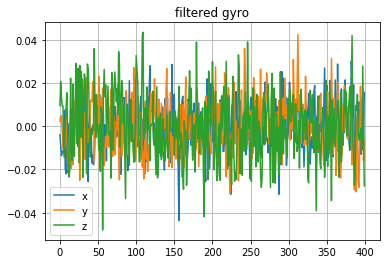

In [54]:
fgx = signal.lfilter(b,a, [g[0] for g in gyros])
fgy = signal.lfilter(b,a, [g[1] for g in gyros])
fgz = signal.lfilter(b,a, [g[2] for g in gyros])

plt.plot(fgx, label='x')
plt.plot(fgy, label='y')
plt.plot(fgz, label='z')
plt.grid(True)
plt.legend()
plt.title('filtered gyro');